In [30]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import sem, probplot, norm
from sklearn.utils import resample
import os
import statsmodels

In [3]:
# Use root for analysis, instead of notebooks folder. 
# WARNING: Only run this once!
print("Current WD:", os.getcwd())
path_parent = os.path.dirname(os.getcwd())
os.chdir(path_parent)
print("Analysis WD:", os.getcwd())

Current WD: c:\Users\jeffc\source\repos\python-code-snippets\notebooks
Analysis WD: c:\Users\jeffc\source\repos\python-code-snippets


# A/B Testing
- Treatment: Something to which a subject is exposed (ie: a title on a website article, plots of land for a seed)
- Treatment Group: A group of subjects who are exposed to a treatment.
- Control Group: The group that receives the base/standard treatment.
- Randomization: The process of randomly assigning subjects to treatments.
- Subjects: Individuals in a treatment groups (ie: web visitors, seeds)
- Test statistic: The metric used to measure the effect of the treatment.
- Blinding: When the treatment group and/or investigators are unaware of who received which treatment. If both, it's "double blind".
- Proxy Variable: A value that stands in for the real value you care about (ie: clicks or form fills - if sales cycle is long).


# Hypothesis Tests
- Null Hypothesis: The hypothesis that only chance is to blame for a given result.
- Alternative Hypothesis: The counterpoint to the null hypothsis (ie: what you hope to prove).
- One-Way Test: Hypothesis test that counts chance results only in one direction (ie: B is better than A)
- Two-way Test: Hypotehsis test that counts chance results in two directions. (ie: A is different from B - can be better or worse)
    - Many statisticians use this because it's more conservative and to avoid argument. It's the default output in R and scipy. 
    - Note: Not very relevant for "Data Science"

# Resampling
- Permutation Test: Procedure of combining two or more samples together and randomly (or exhaustively) reallocating (reorganizing) the observations to resamples. (aka: "randomization test", "random permutation test", "exact test")
    - Recombine and see if A/B (C, D...) differ from eachother.
- Resampling: Drawing additional samples from an observed data set.
- With or Without Replacement: In sampling, whether to return an item back to the sample before the next draw.

C:\Users\jeffc\AppData\Local\Temp\ipykernel_23340\752814039.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  homepagebyday["time_per_pageview"] = homepagebyday.apply(lambda x: x["ga_timeonpage_sec"]/x["ga_pageviews"], axis=1)


Text(0, 0.5, 'Avg Time on Page')

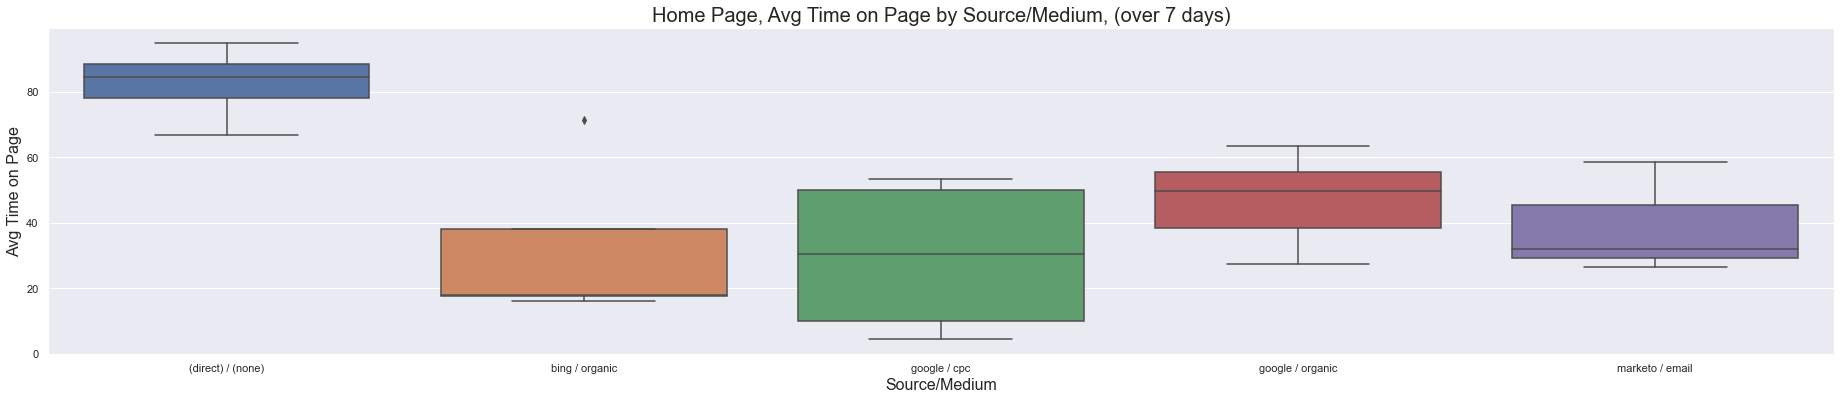

In [12]:
df = pd.read_csv("data/raw/ga_sevendaysessions.csv")

# filter to home page 
homepagebyday = df[(df["ga_landingpage_anon"]=="PAGE0002") & (df["ga_users_count"]>=5)]
homepagebyday["time_per_pageview"] = homepagebyday.apply(lambda x: x["ga_timeonpage_sec"]/x["ga_pageviews"], axis=1)

# Box plot - shows each day of the week's time on page for each source
sns.set(rc={'figure.figsize':(32,6)})
ax = sns.boxplot(data=homepagebyday, x="ga_sourcemedium", y="time_per_pageview")
ax.set_title("Home Page, Avg Time on Page by Source/Medium, (over 7 days)", fontsize=20)
ax.set_xlabel("Source/Medium", fontsize = 16)
ax.set_ylabel("Avg Time on Page", fontsize = 16)

In [15]:
# The difference between direct and bing is 50 seconds, but the question is... is that within the range we'd see with random chance? 
# In other words, we need to determine if it's statistically significant. 
mean_direct = homepagebyday[homepagebyday["ga_sourcemedium"]=="(direct) / (none)"]["time_per_pageview"].mean()
mean_bingorganic = homepagebyday[homepagebyday["ga_sourcemedium"]=="bing / organic"]["time_per_pageview"].mean()
print("Diff:", mean_direct - mean_bingorganic)

Diff: 50.44170599026653


C:\Users\jeffc\AppData\Local\Temp\ipykernel_23340\1943614927.py:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return x.loc[idx_B].mean() - x.loc[idx_A].mean()
C:\Users\jeffc\AppData\Local\Temp\ipykernel_23340\1943614927.py:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return x.loc[idx_B].mean() - x.loc[idx_A].mean()
C:\Users\jeffc\AppData\Local\Temp\ipykernel_23340\1943614927.py:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return x.loc[idx_B].mean() - x.loc[idx_A].mean()
C:\Users\jeffc\AppData\Local\Temp\ipykernel_23340\1943614927.py:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return x.loc[idx_B].mean() - x.loc[idx_A].mean()
C:\Users\jeffc\AppData\Local\Temp\ipykernel_23340\1943614927.py:5: FutureWar

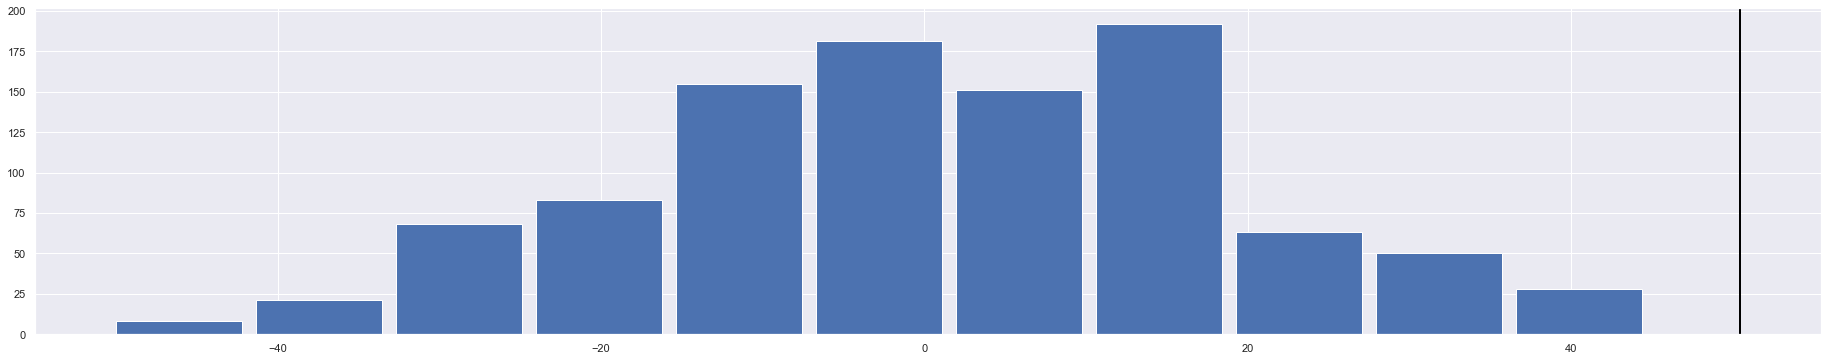

In [29]:
def perm_fun(x, nA, nB):
    n = nA + nB
    idx_B = set(random.sample(range(n), nB))
    idx_A = set(range(n)) - idx_B
    return x.loc[idx_B].mean() - x.loc[idx_A].mean()

nA = homepagebyday[homepagebyday["ga_sourcemedium"]=="(direct) / (none)"].shape[0]
nB = homepagebyday[homepagebyday["ga_sourcemedium"]=="bing / organic"].shape[0]
directandbing=homepagebyday[homepagebyday["ga_sourcemedium"].isin(["bing / organic", "(direct) / (none)"])].reset_index()
random.seed(1)
perm_diffs = [perm_fun(directandbing["time_per_pageview"], nA, nB) for _ in range(1000)]

fig, ax = plt.subplots(figsize=(32,6))
ax.hist(perm_diffs, bins=11, rwidth=0.9)
ax.axvline(x = mean_direct - mean_bingorganic, color="black", lw=2)

**Statistical Singificance?**<br>
Since the black line is outside the distribution, you might conclude that this is statistically significant. 

# Exahustive and Bootstrap Permutation Tests
- Exhaustive: Instead of randomly shuffling, we figured out all the possible ways to combine the data. 
- Bootstrap: Instead of randomly shuffling (without replacement), we sample with replacement. 

# Statistical Significance and p-Values
- p-value: Given a chance model that embodies the null hypothesis, the p-value is the probability of obtaining results as unusual or extreme as the observed results.
    - [ASA Statement on p-Values](https://www.tandfonline.com/doi/full/10.1080/00031305.2016.1154108)
        - Indicates how incomparible the data are with a specified model. 
        - Do not indicate that the studied hypothesis is true.
        - Decisions should not be based solely on p-values.
        - Proper inference requires full reporting and transparency.
        - Does not measure the size of an effect or the importance of a result.
    - For Data Science, they're one useful metric toward a decision.
- Alpha: The probability threshold of unusualness that we'll accept - ie: most commonly 5% (for 95% confidence)... or 1% for 99% confidence.
    - NOT: "What is the probability that this happened by chance?"
    - YES: "Given a chance model, what is the probability of a result this extreme?"
- Type 1 error: Mistakenly concluding an effect is real when it's due to chance.
- Type 2 error: Mistakenly concluding an effect is due to chance when it's real.


In [33]:
from scipy.stats import chi2_contingency
survivors = np.array([[200, 23739 - 200], [182, 22588 - 182]])
chi2, p_value, df, _ = chi2_contingency(survivors)

print(f"p-value for single-sided test: {p_value / 2:.4f}")

p-value for single-sided test: 0.3498


# t-Tests
- Named after the Students T Distribution.
- Test Statistic: A metric for the difference or effect of interest.
- t-statistic: A standardized version of common test statistics such as means.
- t-distribution: A referecnee distribution (ie: dirived from the null hypothesis) to which the observed t-statistic can be compared.

In [37]:
from scipy.stats import ttest_ind

times_direct = homepagebyday[homepagebyday["ga_sourcemedium"]=="(direct) / (none)"]["time_per_pageview"]
times_bingorg = homepagebyday[homepagebyday["ga_sourcemedium"]=="bing / organic"]["time_per_pageview"]

res = ttest_ind(times_direct, times_bingorg, equal_var=False)
print(f"p-value for double-sided test: {res.pvalue:.4f}")
print(f"p-value for single-sided test: {res.pvalue / 2:.4f}")

p-value for double-sided test: 0.0065
p-value for single-sided test: 0.0033


# Multiple Testing
- Type 1 Error: Mistakenly concluding an effect is statistically significant.
- False Discovery Rate: The rate of making Type 1 error over multiple tests
- Alpha Inflation: The alpha (probability of making Type 1 error) increases as you test more and more things
- Adjustment of p-values: Accounting for multiple tests
- Overfitting: Fitting to the noise
- In data science, some of this is mitigated by using holdout/test data sets.

# Degrees of Freedom
- the number of values free to vary (aka: "d.f.")
- n: sample size
- Example: 
    - if you have the mean for a sample of 10 values, there are 9 degrees of freedom (n-1)
    - Once you know 9 of the values, the 10th is no longer free - it's known.
- For data science, not that important since the difference between n and n-1 is negligible at high sample size.

# ANOVA
- ANOVA (aka: "Analysis of Variance"): statistical procedure that tests for a statistically significant difference among several groups (ie: A/B/C/D test)
- Pairwise Comparison: A single hypothesis test between two groups among several groups (ie: compare A to B, A to C, and B to C)
- Omnibus Test: A single hypothesis test of the overall veraince among multiple group means
- Decomposition of variance: separation 
- F-Statistic: Can be used like the t-test

In [40]:
import scipy.stats as stats

df = pd.read_csv("data/raw/ga_sevendaysessions.csv")

# filter to home page 
homepagebyday = df[(df["ga_landingpage_anon"]=="PAGE0002") & (df["ga_users_count"]>=5)]
homepagebyday["time_per_pageview"] = homepagebyday.apply(lambda x: x["ga_timeonpage_sec"]/x["ga_pageviews"], axis=1)

times_direct = homepagebyday[homepagebyday["ga_sourcemedium"]=="(direct) / (none)"]["time_per_pageview"]
times_bingorg = homepagebyday[homepagebyday["ga_sourcemedium"]=="bing / organic"]["time_per_pageview"]
times_googlecpc = homepagebyday[homepagebyday["ga_sourcemedium"]=="google / cpc"]["time_per_pageview"]
times_googleorg = homepagebyday[homepagebyday["ga_sourcemedium"]=="google / organic"]["time_per_pageview"]
times_marketo = homepagebyday[homepagebyday["ga_sourcemedium"]=="marketo / email"]["time_per_pageview"]

res = stats.f_oneway(times_direct, times_bingorg, times_googlecpc, times_googleorg, times_marketo)
print(f'F-Statistic: {res.statistic / 2:.4f}')
print(f'p-value (one-way): {res.pvalue / 2:.4f}')

F-Statistic: 4.5158
p-value: 0.0001


C:\Users\jeffc\AppData\Local\Temp\ipykernel_23340\1119776533.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  homepagebyday["time_per_pageview"] = homepagebyday.apply(lambda x: x["ga_timeonpage_sec"]/x["ga_pageviews"], axis=1)


In [39]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

model = smf.ols('time_per_pageview ~ ga_sourcemedium', data=homepagebyday).fit()
                
aov_table = sm.stats.anova_lm(model)
print(aov_table)

c:\Users\jeffc\PythonEnvs\DataSciJobs2\lib\site-packages\statsmodels\compat\pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


                   df        sum_sq      mean_sq         F    PR(>F)
ga_sourcemedium   4.0  11144.774802  2786.193701  9.031617  0.000209
Residual         21.0   6478.360048   308.493336       NaN       NaN


# Chi-Square Test
- A measure of the extent to which some observed data departs from expectation.
- Expectation: How we would expect the data to turn out under some assumption (ie: the null hypothesis)
- Degrees of Freedom calculated by the rows (r) and columns (c): (r-1) x (c-1)

In [84]:
# Calculating chi-square statistic
import math

# Test values - 3 tests...
testing = np.array([[14, 8, 12], [986, 992, 988]])
print("TESTING...")
print(testing)

# Expected Values
expected_clicks = testing[0].sum()/3
expected_noclicks = testing[1].sum()/3

firstrow = (np.ones(3)*expected_clicks)
secondrow = (np.ones(3)*expected_noclicks)
expected = np.array((firstrow, secondrow))

print("EXPECTED...")
print(expected)

# Difference between testing and expected
print("DIFF...")
def pearsonresidual(obs, exp):
    return (obs-exp)/math.sqrt(exp)
    
vfunc = np.vectorize(pearsonresidual)
pres = vfunc(testing, expected)
print(pres)

# Calculate Chi-Square (sum of squared pearson residuals)
chisquare = np.square(pres).sum()
print("Chi-Square...")
print(chisquare)

TESTING...
[[ 14   8  12]
 [986 992 988]]
EXPECTED...
[[ 11.33333333  11.33333333  11.33333333]
 [988.66666667 988.66666667 988.66666667]]
DIFF...
[[ 0.79211803 -0.99014754  0.19802951]
 [-0.08480936  0.1060117  -0.02120234]]
Chi-Square...
1.6659394708658917


In [86]:
# Resampling approach
box = [1] * 34
box.extend([0] * 2966)
random.shuffle(box)

clicks = pd.DataFrame(testing, columns=["Headline-A", "Headline-B", "Headline-C"])

def chi2(observed, expected):
    pearson_residuals = []
    for row, expect in zip(observed, expected):
        pearson_residuals.append([(observe - expect) ** 2 / expect
                                  for observe in row])
    # return sum of squares
    return np.sum(pearson_residuals)

expected_clicks = 34 / 3
expected_noclicks = 1000 - expected_clicks
expected = [34 / 3, 1000 - 34 / 3]
chi2observed = chi2(clicks.values, expected)

def perm_fun(box):
    sample_clicks = [sum(random.sample(box, 1000)),
                     sum(random.sample(box, 1000)),
                     sum(random.sample(box, 1000))]
    sample_noclicks = [1000 - n for n in sample_clicks]
    return chi2([sample_clicks, sample_noclicks], expected)

perm_chi2 = [perm_fun(box) for _ in range(2000)]

resampled_p_value = sum(perm_chi2 > chi2observed) / len(perm_chi2)
print(f'Observed chi2: {chi2observed:.4f}')
print(f'Resampled p-value: {resampled_p_value:.4f}')

Observed chi2: 1.6659
Resampled p-value: 0.4805


In [87]:
chisq, pvalue, df, expected = stats.chi2_contingency(clicks)
print(f'Observed chi2: {chisq:.4f}')
print(f'p-value: {pvalue:.4f}')

Observed chi2: 1.6659
p-value: 0.4348


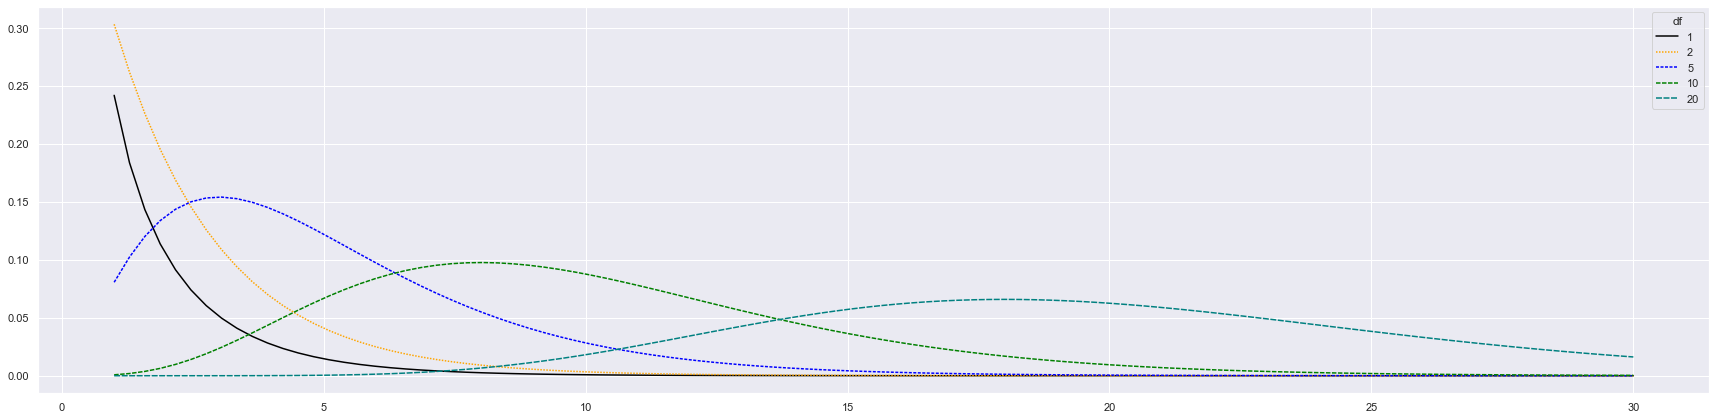

In [91]:
# Chi-square Distribution

x = [1 + i * (30 - 1) / 99 for i in range(100)]

chi = pd.DataFrame({
    'x': x,
    'chi_1': stats.chi2.pdf(x, df=1),
    'chi_2': stats.chi2.pdf(x, df=2),
    'chi_5': stats.chi2.pdf(x, df=5),
    'chi_10': stats.chi2.pdf(x, df=10),
    'chi_20': stats.chi2.pdf(x, df=20),
})
fig, ax = plt.subplots(figsize=(24, 6))
ax.plot(chi.x, chi.chi_1, color='black', linestyle='-', label='1')
ax.plot(chi.x, chi.chi_2, color='orange', linestyle=(0, (1, 1)), label='2')
ax.plot(chi.x, chi.chi_5, color='blue', linestyle=(0, (2, 1)), label='5')
ax.plot(chi.x, chi.chi_10, color='green', linestyle=(0, (3, 1)), label='10')
ax.plot(chi.x, chi.chi_20, color='teal', linestyle=(0, (4, 1)), label='20')
ax.legend(title='df')

plt.tight_layout()
plt.show()



# Multi-Arm Bandit
- An imaginary slot machine with multiple arms (each with a different payoff)
- Arm: A treatment in an experiment
- Win: The result/expectation (ie: user clicks link)

# Power and Sample Size
- Effect Size: The minimum size of the effect that you hope to be able to detect in a statistical test
- Power: The probability of detecting a given effect size with a given sample size
- Significance Level: The significance level (alpha) at which the test will be conducted.

In [92]:
# Sample Size, Effect Size, Significance Level, Power - given 3, you can calculate the fourth.
# Want sample size...
effect_size = sm.stats.proportion_effectsize(0.0121, 0.011)
analysis = sm.stats.TTestIndPower()
result = analysis.solve_power(effect_size=effect_size, 
                              alpha=0.05, power=0.8, alternative='larger')
print('Sample Size: %.3f' % result)



Sample Size: 116602.393


In [93]:
effect_size = sm.stats.proportion_effectsize(0.0165, 0.011)
analysis = sm.stats.TTestIndPower()
result = analysis.solve_power(effect_size=effect_size, 
                              alpha=0.05, power=0.8, alternative='larger')
print('Sample Size: %.3f' % result)

Sample Size: 5488.408
